<a href="https://colab.research.google.com/github/CLAIR-LAB-TECHNION/ICAPS-24/blob/main/ICAPS_SummerSchool_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Installations

In [ ]:
!pip install "git+https://github.com/CLAIR-LAB-TECHNION/ICAPS-24"

  Cloning https://github.com/CLAIR-LAB-TECHNION/ICAPS-24 to /tmp/pip-req-build-bgc1l0pb
  Running command git clone --filter=blob:none --quiet https://github.com/CLAIR-LAB-TECHNION/ICAPS-24 /tmp/pip-req-build-bgc1l0pb
  Resolved https://github.com/CLAIR-LAB-TECHNION/ICAPS-24 to commit 294cf22c51cbe83ac369fb282fec6d92758a613a
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 17.4 MB/s eta 0:00:00
  Created wheel for ICAPS-24: filename=ICAPS_24-0.1.0-py3-none-any.whl size=19651969 sha256=b43e7ae67e08603acf22d6a6aec6aac37ddefe35fc4ad7a279df041f

In [ ]:
%env MUJOCO_GL=egl

env: MUJOCO_GL=egl


In [ ]:
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.8 MB/s eta 0:00:00


## Imports

In [ ]:
import mediapy as media
import numpy as np
from numpy import pi

# Introduction to continuous N table blocks World

In [ ]:
from n_table_blocks_world.n_table_blocks_world import NTableBlocksWorld
env = NTableBlocksWorld(render_mode="rgb_array")
state = env.reset()
print(state)

{'robot_joint_pos': array([ 4.36254124e-05, -1.57031639e+00,  1.44185993e-04,  1.00867864e-04,
       -1.38248476e-05,  9.96726376e-09]), 'robot_joint_velocities': array([ 3.32137057e-03, -1.37949741e-02, -4.05636768e-03,  1.34886132e-02,
       -1.87691326e-03, -3.28900405e-06]), 'gripper_state_closed': False, 'object_positions': {'block 1 red': array([-0.1       ,  0.55      ,  0.72986352]), 'block 2 yellow': array([0.1       , 0.5       , 0.72986352]), 'block 3 cyan': array([0.2       , 0.63      , 0.72986352]), 'block 4 purple': array([0.24      , 0.39      , 0.72986352]), 'block 5 red': array([-0.2       , -0.52      ,  0.72986352]), 'block 6 yellow': array([ 0.1       , -0.51      ,  0.72986352]), 'block 7 cyan': array([-0.07      , -0.65      ,  0.72986352]), 'block 8 purple': array([-0.1       , -0.4       ,  0.72986352]), 'block 9 red': array([6.00000000e-01, 4.44089210e-20, 7.29761806e-01]), 'block 10 yellow': array([ 6.00000000e-01, -1.77635684e-20,  7.60335562e-01])}}



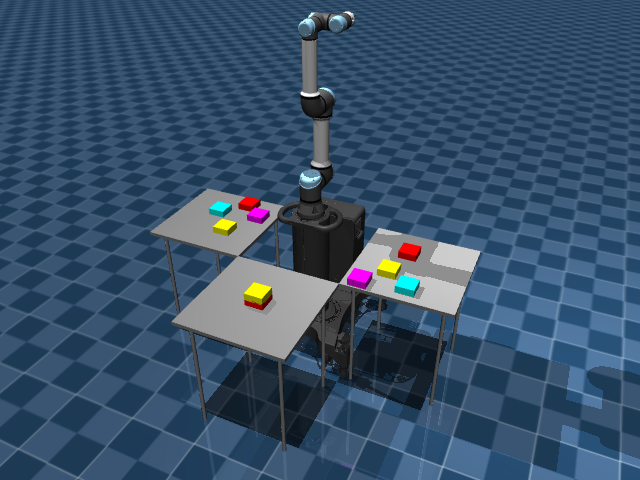

In [ ]:
im = env.render()
media.show_image(im)

In [ ]:
%%script false --no-raise-error

framerate = 60
frames = []

state = env.reset()

# move to all joints at -45 degrees, for 100 steps:
action = [-pi/4]*6
for i in range(100):
    state = env.step(action)
    frames.append(env.render())

# move to another config for 100 steps:
action = [0, -pi/2, pi/2, 0, 0, 0]
for i in range(100):
    state = env.step(action)
    frames.append(env.render())

# show video:
media.show_video(frames, fps=framerate)

From now and on, to reduce runtime, let's not render after every step, but every 8 steps. We can change it when we want better looking videos.

Here we implement a convenience function, that moves the robot to a desired config. We can use it instead of rewriting the loop every time. It can also be set to stop automatically when reaching the desiried config, and when the robot joints velocity is low enough.
This method also create frames for video, in a desired frequency.

In [ ]:
def move_to(env, target_config, tolerance=0.05, end_vel=0.1, max_steps=None,
            render_freq=8):
    '''
    move robot joints to target config, until it is close within tolerance,
    or max_steps exceeded.
    @param target_joint_pos: position to move to
    @param tolerance: distance withing configuration space to target to consider
     as reached
    @param max_steps: maximum steps to take before stopping, no limit if None
    @param render_freq: how often to render and append a frame
    @return: success, frames
    '''
    joint_positions = env.robot_joint_pos
    joint_velocities = env.robot_joint_velocities

    frames = []

    i = 0
    while np.linalg.norm(joint_positions - target_config) > tolerance \
    or np.linalg.norm(joint_velocities) > end_vel:
        if max_steps is not None and i > max_steps:
            return False, frames

        state = env.step(target_config)
        joint_positions = state['robot_joint_pos']
        joint_velocities = state['robot_joint_velocities']

        if i % render_freq == 0:
            frames.append(env.render())

        i += 1

    return True, frames

In [ ]:
framerate = 8
render_freq = 8

env.reset()

config1 = [-pi/4]*6
success, frames1 = move_to(env, config1)

config2 = [0, -pi/2, pi/2, 0, 0, 0]
success, frames2 = move_to(env, config2)

frames = np.concatenate([frames1, frames2])

# show video:
media.show_video(frames, fps=framerate)

## Exercise
Try to move the end effector of the robotic arm to be above the yellow block that is on the right table. complete the code in the following cell:

In [ ]:
%%script false --no-raise-error

# choose a config that will bring the end effector to be above the yellow
# block that is on the right table. This configuration will be used as an action
above_right_yellow_block = # TODO - your code here

success, frames = move_to(env, above_right_yellow_block)
media.show_video(frames, fps=framerate)

In [ ]:
# proposed solution:
above_right_yellow_block = [-0.6, -0.6, 1.7, 0.7, pi/2, 0]

success, frames = move_to(env, above_right_yellow_block)
media.show_video(frames, fps=framerate)

## moving to position with inverse kinematics

let's extract the cartesian coordinates of the yellow block, and set a target position for the robot end effector, which is 10 centimeters above the block to be able to grasp it.

In [ ]:
object_positions = state['object_positions']
target_position = object_positions['block 2 yellow']
target_position[2] += 0.1  # add 10 centimeters to Z axis
print("target position:", target_position)

target position: [0.1        0.5        0.82986352]


We also need to choose target orientation of the end effector. We want it to face down to pick up blocks, we provide target orientation as a rotation matrix.

In [ ]:
facing_down_R = [[0, 0, -1],
                 [0, 1, 0],
                 [1, 0, 0]]

We have created a motion planning utility class that implements inverse kinematics, and other methods that we will use and explain about later. Let's use it to find an inverse kinematic solution where the end effector is facing down, and is above the yellow box:

In [ ]:
from motion_planning.motion_planner import NTableBlocksWorldMotionPlanner

motion_planner = NTableBlocksWorldMotionPlanner()
above_yellow_block_config = motion_planner.ik_solve(goal_pos=target_position,
                                                    goal_R=facing_down_R,)
print(above_yellow_block_config)


[-0.4131408509600138, -0.5867665583841634, 2.0310915812277957, -3.0151252613502733, -1.5707967701871617, 1.1576553276043586]


Let's test this solution:

In [ ]:
env.reset()
success, frames = move_to(env, above_yellow_block_config, max_steps=200)
media.show_video(frames, fps=framerate)

### moving a block

In [ ]:
drop_position = object_positions['block 8 purple']
drop_position[2] += 0.1
above_purple_block_config = motion_planner.ik_solve(goal_pos=drop_position,
                                                    goal_R=facing_down_R,)

env.set_gripper(True)
success, frames = move_to(env, above_purple_block_config, max_steps=100)
env.set_gripper(False)

media.show_video(frames, fps=framerate)


no ik solution found


# Motion Planning
____
Yuval: If this tutorial is not too long, a possible extention would be to dig deeper here into motion planning, show how configurations are sampled and etc...
____

Our motion planner has a model of the world which is used to plan. It can sample robot config and use this model to check if there are collisions. Let's have a look at a visualization of how the motion planner sees the world

In [ ]:
motion_planner.set_config(above_yellow_block_config)
motion_planner.visualize()

You can use the mouse to move the viewpoint, press ctrl to translate and shift to zoom in and out.

Note that this is a simplified representation of the world, for example: the tables legs are ommited, the robot mount is represented as a box, and the robot 3D model is less detailed. This simplification is for efficnency. Since every time the motion planner samples a configuration, it uses geometry computation to check for collision, the more complex our 3D world is, the more time it will take to check for collision when looking for a path.
With an exact model, such as in our simulator, finding a path could take a minute instead of a few seconds.

## Managing Objects in the Motion Planner
Note that there are no blocks in our motion planner world, thus it won't consider possible collision with them when planning. This may result a plan in which the robot collides with blocks which will move or drop them from the table. Let's add the blocks to the motion planner.

We have a method to add blocks with names. We will use the names that are given in the state.

In [ ]:
state = env.reset()
blocks_state = state['object_positions']
print(blocks_state)

{'block 1 red': array([-0.1       ,  0.55      ,  0.72986352]), 'block 2 yellow': array([0.1       , 0.5       , 0.72986352]), 'block 3 cyan': array([0.2       , 0.63      , 0.72986352]), 'block 4 purple': array([0.24      , 0.39      , 0.72986352]), 'block 5 red': array([-0.2       , -0.52      ,  0.72986352]), 'block 6 yellow': array([ 0.1       , -0.51      ,  0.72986352]), 'block 7 cyan': array([-0.07      , -0.65      ,  0.72986352]), 'block 8 purple': array([-0.1       , -0.4       ,  0.72986352]), 'block 9 red': array([6.00000000e-01, 4.44089210e-20, 7.29761806e-01]), 'block 10 yellow': array([ 6.00000000e-01, -1.77635684e-20,  7.60335562e-01])}


In [ ]:
for name, pos in blocks_state.items():
    motion_planner.add_block(name, pos)

motion_planner.visualize()

Now the motion planner considers the blocks as well, but every time we plan a motion, the blocks may be at different positions. We have to update the position of a block every time it moves, so the motion planner will "see" the world as it is. We can do that using the method *move_block(name, pos)*.

Let's create a convinient function that will update the position of all blocks given a state. We have to remember to call it after each manipulation.

In [ ]:
def update_blocks_positions(motion_planner, blocks_positions_dict):
    for name, pos in blocks_positions_dict.items():
        motion_planner.move_block(name, pos)

When the robot grasps a block, it should consider that the blocks moves with the end effector for collision detection. The block practically becomes part of the robot. The following methods allows to attach and detach block from the end effector for the next motion plan:

In [ ]:
motion_planner.attach_box_to_ee()
motion_planner.set_config([0, -pi/2, 0, 0, 0, 0])
motion_planner.visualize()

In [ ]:
motion_planner.detach_box_from_ee()
motion_planner.visualize()

## Finding a Path
Now let's see how to use our motion planner to find path. We can use *plan_from_config_to_pose* method to pass an initial robot configuration, and goal pose of the end effector. The output is a path, which is a list of configurations. The first configuration on the list is the start config, the last is the configuration where the end effector is at the desired pose, and the robot can move straight from each config to it's subsequent without collision (In a straight line in **configuration space**).

In [ ]:
path = motion_planner.plan_from_config_to_pose(
    start_config=above_yellow_block_config,
    goal_R=facing_down_R,
    goal_pos=drop_position,
    )


planning...
planning...
planning...
planning...
planning...
planning...


In [ ]:
print(path)

[[-0.4131408509600138, -0.5867665583841634, 2.0310915812277957, -3.0151252613502733, -1.5707967701871617, 1.1576553276043586], [-0.35430155212395764, -2.4409187353577213, -0.005175951856501992, 1.07759186677918, -1.0541905238191225, -0.6274034044079624], [0.02286525523120316, -2.555154363980145, -2.2882634175062835, 0.13104120957768914, 1.5708017407757853, -1.5479514427945318]]


We can visualize the path as animation using the following method:

In [ ]:
motion_planner.visualize_path(path)

## Path Execution

In [ ]:
env.reset()
success, frames = move_to(env, above_yellow_block_config, max_steps=200)

env.set_gripper(True)

frames_all = []
for p in path:
    success, frames = move_to(env, p, max_steps=200)
    frames_all.extend(frames)
media.show_video(frames_all, fps=framerate)

## Wrapping it All Up
Now that we know how to plan a path and execute it, let's create helper functions that wraps it all up to a single movement command.

First, let's create path execution helper function that moves the robot along a path, and saves the image frames:

*TODO: make this an exercise (to complete part of the code)*

In [ ]:
def execute_path(env, path, tolerance=0.05, end_vel=0.1,
                 max_steps_per_section=200, render_freq=8):
    """
    execute a path of joint positions
    @param path: list of joint positions to follow
    @param tolerance: distance withing configuration space to target to consider as reached to each point
    @param end_vel: maximum velocity to consider as reached to each point
    @param max_steps_per_section: maximum steps to take before stopping at each section
    @param render_freq: how often to render and append a frame
    @return: success, frames
    """
    frames = []
    for config in path:
        success, frames_curr = move_to(env,
                                       config,
                                       tolerance=tolerance,
                                       end_vel=end_vel,
                                       max_steps=max_steps_per_section,
                                       render_freq=render_freq)
        frames.extend(frames_curr)
        if not success:
            return False, frames

    return True, frames

In [ ]:
def move_to_pose(env, motion_planner, target_position,
                 target_orientation=facing_down_R, tolerance=0.05,
                 end_vel=0.1, max_steps_per_section=200, render_freq=8):
    """
    move robot to target position and orientation, and update the motion planner
    with the new state of the blocks
    @param target_position: position to move to
    @param target_orientation: orientation to move to
    @param tolerance: distance withing configuration space to target to consider as reached
    @param max_steps_per_section: maximum steps to take before stopping a section
    @param render_freq: how often to render and append a frame
    @return: success, frames
    """
    joint_state = env.robot_joint_pos
    path = motion_planner.plan_from_config_to_pose(joint_state, target_position,
                                                   target_orientation)
    success, frames = execute_path(env,
                                   path,
                                   tolerance=tolerance,
                                   end_vel=end_vel,
                                   max_steps_per_section=max_steps_per_section,
                                   render_freq=render_freq)

    # after executing a motion, blocks position can change, update the motion planner:
    update_blocks_positions(motion_planner, env.get_state()['ob'])

    return success, frames

In [ ]:
def move_above_block(env, motion_planner, block_name, offset=0.1,
                     tolerance=0.05, end_vel=0.1, max_steps_per_section=400,
                     render_freq=8):
    """
    move robot above a block
    @param block_name: name of the block to move above
    @param offset: how much above the block to move
    @param tolerance: distance withing configuration space to target to consider as reached
    @param max_steps_per_section: maximum steps to take before stopping a section
    @param render_freq: how often to render and append a frame
    @return: success, frames
    """
    block_pos = env.get_object_pos(block_name)
    target_position = block_pos + np.array([0, 0, offset])
    return move_to_pose(env, motion_planner, target_position,
                        tolerance=tolerance, end_vel=end_vel,
                        max_steps_per_section=max_steps_per_section,
                        render_freq=render_freq)

In [ ]:
state = env.reset()
state['object_positions']

{'block 1 red': array([-0.1       ,  0.55      ,  0.72986352]),
 'block 2 yellow': array([0.1       , 0.5       , 0.72986352]),
 'block 3 cyan': array([0.2       , 0.63      , 0.72986352]),
 'block 4 purple': array([0.24      , 0.39      , 0.72986352]),
 'block 5 red': array([-0.2       , -0.52      ,  0.72986352]),
 'block 6 yellow': array([ 0.1       , -0.51      ,  0.72986352]),
 'block 7 cyan': array([-0.07      , -0.65      ,  0.72986352]),
 'block 8 purple': array([-0.1       , -0.4       ,  0.72986352]),
 'block 9 red': array([6.00000000e-01, 4.44089210e-20, 7.29761806e-01]),
 'block 10 yellow': array([ 6.00000000e-01, -1.77635684e-20,  7.60335562e-01])}

In [ ]:
success, frames1 = move_above_block(env, motion_planner, 'block 2 yellow')
env.set_gripper(True)
motion_planner.attach_box_to_ee()

success, frames2 = move_above_block(env, motion_planner, 'block 8 purple')
env.set_gripper(False)
motion_planner.detach_box_from_ee()

success, frames3 = move_above_block(env, motion_planner, 'block 10 yellow')
env.set_gripper(True)
motion_planner.attach_box_to_ee()

success, frames4 = move_above_block(env, motion_planner, 'block 2 yellow')
env.set_gripper(False)
motion_planner.detach_box_from_ee()

planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...


KeyError: 'ob'

In [ ]:
frames = np.concatenate([frames1, frames2, frames3, frames4])
media.show_video(frames, fps=framerate)

**Note that plans are not optimal, can use anytime planning to improve...**


# intro to motions
* config and work space, task space
* 2 joint robotic arm example?
* fw/inv kinematic
* code example of our simulator - inv kinematics
    * task - move to be above some block

# motion planning
* collision example - when trying to move from two configs above different tables
* sampling based mp

# code - our motion planner using example
* Run from current config to target pose
* show how the world is modeled for the motion planner: approximated obstacles, sampling configurations
* motion plan execution
    * task - move between cubes

# Discussion (teaser for next lab)
* Connect motion planning space to task space
    * the command for our motion planner is a continous coordinate, but the task uses symbolic state (on table1, on block x)
    * we need grounding between symbolic states and real world states
    * this is complex, each symbolic state can correspond to many continous state (where on the table? which red block?)



In [ ]:
!ls /usr/local/lib/python3.10/dist-packages/motion_planning/

In [ ]:
!cat /usr/local/lib/python3.10/dist-packages/motion_planning/klampt_world.xml